In [1]:
# Goal of this notebook is to implement the dynamical model of Neggers et al. (2006).
# Figure 4 of Neggers et al. (2006) is reproduced, but the equilibrium values do not coincide with theirs.
# They coincide with those published by Youtong Zheng here https://github.com/youtongzheng/Neggers_2006.

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts/ABL_BULK/')
import neggers_etal_2006

In [ ]:
%load_ext autoreload
%autoreload 2

# Neggers et al. (2006) model

The model numerically solves the following three equations for the ABL height $h$, total specific humidity $q_t$ and liquid water potential temperature $\theta_l$
$$ \frac{\partial h}{\partial t} = E + w - M $$
$$ h\frac{\partial q_t}{\partial t} = \overline{w'q_t'}_s + E \Delta q_t + hF_{adv,q_t} $$
$$ h\frac{\partial \theta_l}{\partial t} = \overline{w'\theta_l'}_s + E\Delta\theta_l + hF_{adv,\theta_l} + hF_{rad}, $$
where the surface fluxes are represented with the bulk formulae
$$\overline{w'q_t'}_s = |\boldsymbol{u}_s|C_q^s(q_t^s-q_t)$$
$$\overline{w'\theta_l'}_s = |\boldsymbol{u}_s|C_\theta^s(\theta_l^s-\theta_l)$$
with  $C_q^s = C_\theta^s = 0.0012$, $\boldsymbol{u}_s$ being the surface wind and $q_t^s$ and $\theta_l^s$ the surface properties. The symbol $\Delta$ denotes the jump across the transition layer and not the difference between the free atmosphere and ABL values.

Remind that the liquid water potential temperature can be approximated with 
$$ \theta_l = \theta - \frac{L_v}{c_{pd}}r_l,$$
with $L_v$ the latent heat of vaporization, $c_{pd}$ the specific heat of dry air at constant pressure and $r_l$ the liquid water mixing ratio.

Starting from the equation for $h$, the entrainment $E$ has the units of a velocity and it appears in the virtual potential temperature flux at the ABL top as
$$\overline{w'\theta_v'}_h = E\Delta\theta. $$
From the definition of virtual potential temperature, $\theta_v = \theta(1+0.61q_t-1.61q_l)$, assuming no liquid water, $q_l = 0$, the jump in $\theta_v$ at the ABL top can be explicitly written as
$$\Delta\theta_v = \Delta\theta+ 0.61(\theta\Delta q_t+q_t\Delta\theta+\Delta q_t\Delta\theta).$$

The transition layer jumps are related to the difference w.r.t. the free atmospheric values with some transfer coefficients that represent the cloud layer
$$\Delta q_t = C_q^c (q_t^+-q_t)$$
$$\Delta \theta_l = C_\theta^c (\theta_l^+-\theta_l),$$
with $C_q^c = 0.1$ and $C_\theta^c = 0.03$ from LES hourly mean profiles.

Similarly, the link between the virtual potential temperature flux and the other fluxes is 
$$\overline{w'\theta_v'} = (1+0.61q_t)\overline{w'\theta_l'} + 0.61\theta\overline{w'q_t'}$$
(Cuijpers and Betchold, 1995), neglecting the liquid water specific humidity term.

But the ABL top virtual potential temperature flux has been shown to be proportional to the surface virtual potential temperature flux as
$$ \overline{w'\theta_v'}_h = -0.2 \overline{w'\theta_v'}_s. $$
Thus, the entrainment can be written as 
$$ E = 0.2\frac{\overline{w'\theta_v'}_s}{\Delta\theta_v} $$

The vertical velocity at the ABL top, $w$, is easily imposed as a boundary condition, knowing the large scale subsidence $D$, through mass conservation, namely
$$ w = -hD .$$

The mass flux term $M$ is parameterized as the product of a vertical velocity scale, which has been identified with the Deardorff convective velocity scale $w_*$, and a fractional area of shallow convection $a_c$. Thus,
$$ M = a_cw_*,$$
with 
$$ w_* = (h\overline{w'b'}_s)^{1/3}, $$
$\overline{w'b'}_s = g\overline{w'\theta_v'}_s/\theta_v$ being the surface buoyancy flux. The moist convective area fraction is written as a function of the normalized saturation deficit at the ABL top, namely
$$a_c = 0.5 + 0.36 \arctan\left(1.55\frac{q_t-q_{sat}}{\sigma_q}\right),$$
where $q_{sat}$ is the saturation specific humidity at the ABL top and $\sigma_q^2$, the specific humidity turbulent variance at the ABL top, can be expressed as
$$ \sigma_q^2 = -\frac{h}{w_*}\frac{\Delta q_t}{\Delta z}\overline{w'q_t'}_s.$$
$\Delta z=100$ m is the estimated depth of the cloud transition layer.

In [2]:
# Define some meteorological functions from pycoare.
def qsat(t,p):
    """
    usage: es = qsat(t,p)
    Returns saturation vapor pressure es (mb) given t(C) and p(mb).
    After Buck, 1981: J.Appl.Meteor., 20, 1527-1532
    Returns ndarray float for any numeric object input.
    """
    from numpy import copy, asarray, exp

    t2 = copy(asarray(t, dtype=float))  # convert to ndarray float
    p2 = copy(asarray(p, dtype=float))
    es = 6.1121 * exp(17.502 * t2 / (240.97 + t2))
    es = es * (1.0007 + p2 * 3.46e-6)
    return es

def qsea(sst,p):
    """
    usage: qs = qsea(sst,p)
    Returns saturation specific humidity (g/kg) at sea surface
    given sst(C) and p(mb) input of any numeric type.
    Returns ndarray float for any numeric object input.
    """
    ex = qsat(sst,p) # returns ex as ndarray float
    es = ex#0.98 * ex # This is the correction for the effect of salinity, which we remove now
    qs = 622*es/(p-0.378*es) # saturation specific humidity
    return qs

In [3]:
# # Version 1.0 released by David Romps on September 12, 2017.
# # Version 1.1 vectorized lcl.R, released on May 24, 2021.
# # 
# # When using this code, please cite:
# # 
# # @article{16lcl,
# #   Title   = {Exact expression for the lifting condensation level},
# #   Author  = {David M. Romps},
# #   Journal = {Journal of the Atmospheric Sciences},
# #   Year    = {2017},
# #   Month   = dec,
# #   Number  = {12},
# #   Pages   = {3891--3900},
# #   Volume  = {74}
# # }
# #
# # This lcl function returns the height of the lifting condensation level
# # (LCL) in meters.  The inputs are:
# # - p in Pascals
# # - T in Kelvins
# # - Exactly one of rh, rhl, and rhs (dimensionless, from 0 to 1):
# #    * The value of rh is interpreted to be the relative humidity with
# #      respect to liquid water if T >= 273.15 K and with respect to ice if
# #      T < 273.15 K. 
# #    * The value of rhl is interpreted to be the relative humidity with
# #      respect to liquid water
# #    * The value of rhs is interpreted to be the relative humidity with
# #      respect to ice
# # - return_ldl is an optional logical flag.  If true, the lifting deposition
# #   level (LDL) is returned instead of the LCL. 
# # - return_min_lcl_ldl is an optional logical flag.  If true, the minimum of the
# #   LCL and LDL is returned.

# def lcl(p,T,rh=None,rhl=None,rhs=None,return_ldl=False,return_min_lcl_ldl=False):

#     import math
#     import scipy.special

#     # Parameters
#     Ttrip = 273.16     # K
#     ptrip = 611.65     # Pa
#     E0v   = 2.3740e6   # J/kg
#     E0s   = 0.3337e6   # J/kg
#     ggr   = 9.81       # m/s^2
#     rgasa = 287.04     # J/kg/K 
#     rgasv = 461        # J/kg/K 
#     cva   = 719        # J/kg/K
#     cvv   = 1418       # J/kg/K 
#     cvl   = 4119       # J/kg/K 
#     cvs   = 1861       # J/kg/K 
#     cpa   = cva + rgasa
#     cpv   = cvv + rgasv

#     # The saturation vapor pressure over liquid water
#     def pvstarl(T):
#         return ptrip * (T/Ttrip)**((cpv-cvl)/rgasv) * math.exp( (E0v - (cvv-cvl)*Ttrip) / rgasv * (1/Ttrip - 1/T) )

#     # The saturation vapor pressure over solid ice
#     def pvstars(T):
#         return ptrip * (T/Ttrip)**((cpv-cvs)/rgasv) * math.exp( (E0v + E0s - (cvv-cvs)*Ttrip) / rgasv * (1/Ttrip - 1/T) )

#     # Calculate pv from rh, rhl, or rhs
#     rh_counter = 0
#     if rh  is not None:
#         rh_counter = rh_counter + 1
#     if rhl is not None:
#         rh_counter = rh_counter + 1
#     if rhs is not None:
#         rh_counter = rh_counter + 1
#     if rh_counter != 1:
#         print(rh_counter)
#         exit('Error in lcl: Exactly one of rh, rhl, and rhs must be specified')
#     if rh is not None:
#       # The variable rh is assumed to be 
#       # with respect to liquid if T > Ttrip and 
#       # with respect to solid if T < Ttrip
#         if T > Ttrip:
#             pv = rh * pvstarl(T)
#         else:
#             pv = rh * pvstars(T)
#         rhl = pv / pvstarl(T)
#         rhs = pv / pvstars(T)
#     elif rhl is not None:
#         pv = rhl * pvstarl(T)
#         rhs = pv / pvstars(T)
#         if T > Ttrip:
#             rh = rhl
#         else:
#             rh = rhs
#     elif rhs is not None:
#         pv = rhs * pvstars(T)
#         rhl = pv / pvstarl(T)
#         if T > Ttrip:
#             rh = rhl
#         else:
#             rh = rhs
#     if pv > p:
#         return NA

#     # Calculate lcl_liquid and lcl_solid
#     qv = rgasa*pv / (rgasv*p + (rgasa-rgasv)*pv)
#     rgasm = (1-qv)*rgasa + qv*rgasv
#     cpm = (1-qv)*cpa + qv*cpv
#     if rh == 0:
#         return cpm*T/ggr
#     aL = -(cpv-cvl)/rgasv + cpm/rgasm
#     bL = -(E0v-(cvv-cvl)*Ttrip)/(rgasv*T)
#     cL = pv/pvstarl(T)*math.exp(-(E0v-(cvv-cvl)*Ttrip)/(rgasv*T))
#     aS = -(cpv-cvs)/rgasv + cpm/rgasm
#     bS = -(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T)
#     cS = pv/pvstars(T)*math.exp(-(E0v+E0s-(cvv-cvs)*Ttrip)/(rgasv*T))
#     lcl = cpm*T/ggr*( 1 - \
#       bL/(aL*scipy.special.lambertw(bL/aL*cL**(1/aL),-1).real) )
#     ldl = cpm*T/ggr*( 1 - \
#       bS/(aS*scipy.special.lambertw(bS/aS*cS**(1/aS),-1).real) )

#     # Return either lcl or ldl
#     if return_ldl and return_min_lcl_ldl:
#         exit('return_ldl and return_min_lcl_ldl cannot both be true')
#     elif return_ldl:
#         return ldl
#     elif return_min_lcl_ldl:
#         return min(lcl,ldl)
#     else:
#         return lcl

In [5]:
# def neggers_et_al_2006(t,y,V,SST,D,q_free,th_free,ps):
#     """
#     Subscript s denotes surface values, b stands for buoyancy, which is associated with the virtual potential
#     temperature (theta_v), th indicates the liquid water potential temperature (theta_l) and q the total specific
#     humidity (q_t).
#     """
#     # Define some constants.
#     delta_z = 100.0 # [m]
#     Cqs = 0.0012 # [1], surface exchange coefficient for q
#     Cths = 0.0012 # [1], surface exchange coefficient for theta
#     Cqc = 0.1 # [1], cloud level exchange coefficient for q
#     Cthc = 0.03 # [1], cloud level exchange coefficient for theta
#     Le = 2.5e6 # [J/kg], latent heat of vaporization 
#     cpd  = 1004.67 # [J/K/kg], dry air specific heat at constant pressure
#     Rd = 287.1 # [J/K/kg], dry air gas constant
#     # air density is supposed to be constant and equal to 1...
#     beta = 0.36
#     gamma = 1.55
#     g = 9.81 # [m/s2], acceleration due to gravity
    
#     ### Define some forcing variables for the BOMEX example -> this will be given as input parameters.
#     #V = 8.75 # [m/s], large scale horizontal wind
#     #SST = 300.4 # [K], sea surface temperature
#     #D = 4.3e-6 # [1/s], large scale divergence
#     #q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
#     #th_free = 308 # [K], free tropospheric liquid virtual potential temperature
#     F_advq = -1.2e-3/86400 # [kg/kg/s]
#     F_advth = 0.0/86400 # [K/s]
#     F_rad = -2.0/86400 # [K/s]
#     #ps = 1015 # [hPa], surface pressure
#     ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
#     q_s = qsea(SST-273.15,ps)*1e-3 # [kg/kg], surface total specific humidity (saturation value)
#     th_s = SST*(ref_p/ps)**(Rd/cpd) # [K], surface liquid water potential temperature, assuming no liquid water at the surface
    
#     ### Define some diagnostic variables.
#     # Entrainment.
#     q_flux_s = V*Cqs*(q_s-y[1]) # total specific humidity flux at the surface
#     q_flux_s_CC = V*Cqs*(q_s) # Clausius Clapeyron specific humidity flux at the surface
#     th_flux_s = V*Cths*(th_s-y[2]) # liquid water potential temperature flux at the surface
#     thv_flux_s = (1+0.61*q_s)*th_flux_s + 0.61*th_s*q_flux_s # surface virtual potential temp flux
#     #thv_flux_s = (1+0.61*y[1])*th_flux_s + 0.61*y[2]*q_flux_s # surface virtual potential temp flux
#     delta_q = Cqc*(q_free-y[1])
#     delta_th = Cthc*(th_free-y[2])
#     delta_thv = delta_th + 0.61*(y[1]*delta_th + y[2]*delta_q + delta_q*delta_th)
#     E = 0.2*thv_flux_s/delta_thv
    
# #     A simple parameterization of cloud water related variables for use in boundary layer models
#     # Mass flux.
#     #thv0 = y[2]*(1+0.61*y[1]) # [K], ABL virtual potential temperature
#     thv0 = th_s*(1+0.61*q_s) # [K], Surface virtual potential temperature
#     b_flux_s = g*thv_flux_s/thv0 # surface buoyancy flux
#     w_star = (y[0]*b_flux_s)**(1/3) # m/s, Deardorff convective velocity scale. 5th try
# #    w_star = (g*y[0]*thv_flux_s/(y[2]*(ps/ref_p)**(Rd/cpd)*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 4th try
# #    w_star = (g*y[0]*thv_flux_s/(y[2]*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 3rd try
# #    w_star = (g*y[0]*thv_flux_s/y[2])**(1/3) # m/s, Deardorff convective velocity scale. 2nd try
# #    w_star = (g*y[0]*thv_flux_s/th_s)**(1/3) # m/s, Deardorff convective velocity scale. 1st try
    
#     T0 = y[2]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
#     T_h = T0-g/cpd*y[0] # [K], air temperature at h following a dry adiabat.
#     p_h = ps*100*(1-g*y[0]/(T0*cpd))**(cpd/Rd) # [Pa], air pressure at h with p=rho*R*T; dp/dz=-rho*g; dtheta/dz=0 
#     e_sat_h = qsat(T_h-273.15,p_h/100)*100 # [Pa], saturation vapor pressure at h.
#     q_sat = 0.622*e_sat_h/(p_h-0.378*e_sat_h) # [kg/kg], saturation specific humidity at h.
   
#     sigma_q = np.sqrt(-q_flux_s*delta_q*y[0]/(w_star*delta_z))
#     area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)
#     M = area_c*w_star
    
#     # Define here the mass flux used in Neggers et al. (2019) (also from Naumann et al. 2019) computing the LCL with the exact formula from Romps (2017)
#     tau = 15*60 # adjustment time scale = 15 min
#     LCL = lcl(ps*100,T0,y[1]/q_s)
#     #M = np.heaviside(y[0]-LCL,0)*(y[0]-LCL)/tau

#     # Surface air density.
#     rhos = ps*100/(Rd*T0)
    
#     ### Define the equations to be solved.
#     dh_dt = E - D*y[0] - M 
#     dq_dt = (q_flux_s + E*delta_q)/y[0] + F_advq
#     dth_dt = (th_flux_s + E*delta_th)/y[0] + F_advth + F_rad
    
#     #print(area_c)
#     #print((y[1]-q_sat)*1e3)
#     #print(sigma_q*1e3)
#     #print(w_star)
#     #print((y[1]-q_sat)/sigma_q)
#     area_c_ext.append(area_c)
#     w_star_ext.append(w_star)
#     M_ext.append(M)
#     E_ext.append(E)
#     sigma_q_ext.append(sigma_q)
#     LHF_ext.append(q_flux_s*Le*rhos)
#     LHF_CC_ext.append(q_flux_s_CC*Le*rhos)
#     SHF_ext.append(th_flux_s*cpd*rhos)
#     LCL_ext.append(LCL)
#     qs_ext.append(q_s)
#     qsat_ext.append(q_sat)
    
#     return dh_dt, dq_dt, dth_dt

In [8]:
# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3
q_BL = q_s - q_free   # initial BL moisture; Ale added, 6th Feb 2025

# Input parameters
V = 8.75 # [m/s], large scale horizontal wind
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
ps = 1015 # [hPa], surface pressure

# initial conditions vector  
y0 = [100,q_BL,th_s-2]     # why setting initial moisture to q_free?????

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0
area_c_ext = []
w_star_ext = []
M_ext = []
E_ext = []
sigma_q_ext = []
LHF_ext = []
LHF_CC_ext = []
qs_ext = [] # qsat at the surface, as a function of the SST
qsat_ext = [] # qsat at h
SHF_ext = []
LCL_ext = []
sol = solve_ivp(neggers_etal_2006.neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps))#, t_eval=t_eval)

equilibrium h = 557.85 m
equilibrium LCL = 734.42 m
equilibrium q = 16.04 g/kg
equilibrium th = 299.17 K
equilibrium a$_c$ = 8.01%
equilibrium w$\star$ = 0.6 m/s


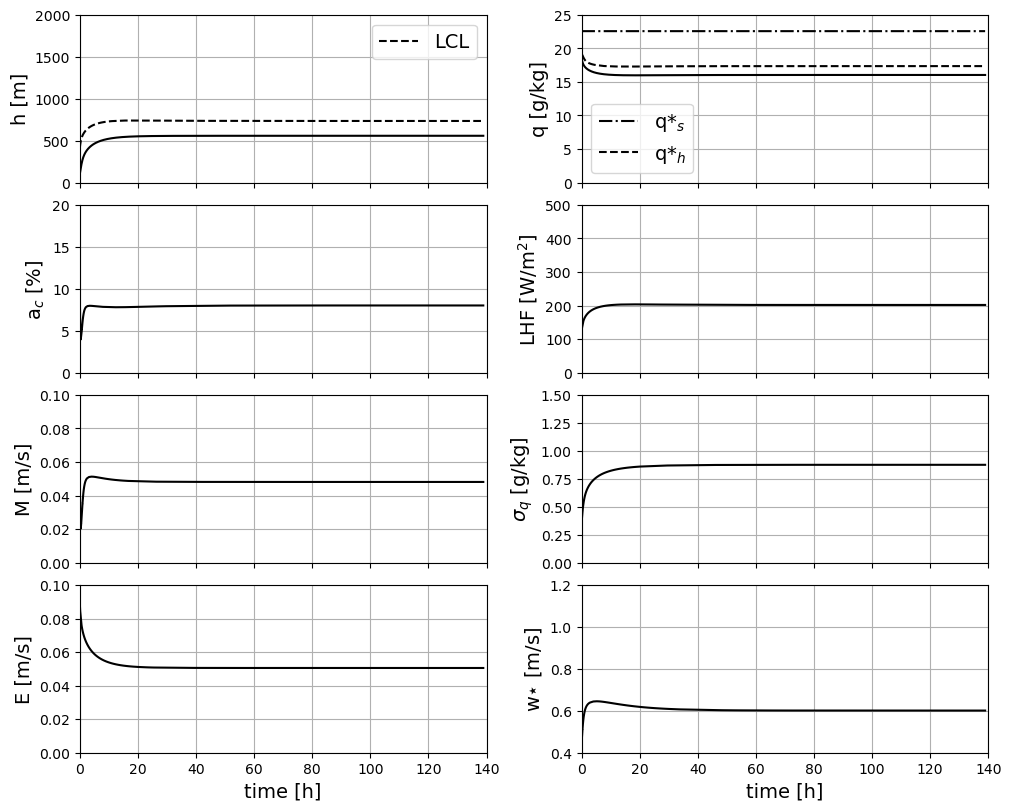

In [10]:
# Plots for a single run.
h = sol.y[0]
q = sol.y[1]
th = sol.y[2]

q_s = qsea(SST-273.15,ps) # [kg/kg], surface total specific humidity (saturation value)
eq_T0 = th[-1]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
eq_LCL = neggers_etal_2006.lcl(ps*100,eq_T0,q[-1]*1e3/q_s)

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final = np.max(sol.t)
dt = t_final/3600/len(E_ext) # [h]
time_ext = np.arange(len(E_ext))*dt

print('equilibrium h = '+str(round(h[-1],2))+' m')
print('equilibrium LCL = '+str(round(eq_LCL,2))+' m')
print('equilibrium q = '+str(round(q[-1]*1e3, 2))+' g/kg')
print('equilibrium th = ' +str(round(th[-1], 2))+' K')
print('equilibrium a$_c$ = '+str(round(area_c_ext[-1]*100, 2))+'%')
print('equilibrium w$\star$ = '+str(round(w_star_ext[-1],2))+' m/s')

fig, ax = plt.subplots(4,2,figsize=(10,8),sharex=True,constrained_layout=True)

ax[0,0].plot(sol.t/3600,h,'k')
ax[0,0].plot(time_ext,LCL_ext,'--k',label='LCL')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()
ax[0,0].legend(fontsize=14)

ax[0,1].plot(sol.t/3600,q*1e3,'k')
ax[0,1].plot(time_ext,np.array(qs_ext)*1e3,'-.k',label='q*$_s$')
ax[0,1].plot(time_ext,np.array(qsat_ext)*1e3,'--k',label='q*$_h$')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].set_ylim(0,25)
ax[0,1].grid()
ax[0,1].legend(fontsize=14)

#plt.plot(sol.t/3600,sol.y[2],'.')
#plt.ylabel('th [K]',fontsize=14)
#plt.xlabel('time [h]',fontsize=14)
#plt.grid()
#plt.show()

ax[1,0].plot(time_ext,np.array(area_c_ext)*100,'k')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()

ax[1,1].plot(time_ext,np.array(LHF_ext),'k')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
ax[1,1].set_ylim(0,500)
ax[1,1].grid()

ax[2,0].plot(time_ext,np.array(M_ext),'k')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(time_ext,np.array(sigma_q_ext)*1e3,'k')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

ax[3,0].plot(time_ext,np.array(E_ext),'k')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].plot(time_ext,np.array(w_star_ext),'k')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[3,0].set_xlabel('time [h]',fontsize=14)
ax[3,1].set_xlabel('time [h]',fontsize=14)
ax[3,0].set_xlim(0,140)
ax[3,1].set_xlim(0,140)

# Define the variables with constant V(_mag), CV
h_CV = h
q_CV = q
area_c_ext_CV = area_c_ext
LHF_ext_CV = LHF_ext
M_ext_CV = M_ext
sigma_q_ext_CV = sigma_q_ext
E_ext_CV = E_ext
w_star_ext_CV = w_star_ext

In [82]:
# Now test the dependence of the solution to some external parameters.

# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2]

# Input parameters
V = 8.75 # [m/s], large scale horizontal wind
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
ps = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

# Neggers et al. (2006) forcing and equilibrium values.
V_N06 = 8.75 # [m/s], large scale horizontal wind
SST_N06 = 300.4 # [K], sea surface temperature
D_N06 = 4.3e-6 # [1/s], large scale divergence
q_free_N06 = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free_N06 = 308 # [K], free tropospheric liquid virtual potential temperature
ps_N06 = 1015 # [hPa], surface pressure
q_s_N06 = qsea(SST_N06-273.15,ps_N06)*1e-3

h_N06 = 692 # m/s
q_N06 = 15 # g/kg
#th_N06 = 
a_c_N06 = 4.3 # %
w_star_N06 = 0.75 # m/s
M_N06 = 0.032 # m/s
h_N06 = 692 # m/s
q_N06 = 15 # g/kg
#th_N06 = 
a_c_N06 = 4.3 # %
w_star_N06 = 0.75 # m/s
M_N06 = 0.032 # m/s

# Set a single parameter to change. Remember to change the name of the variable in the following for loop.
str_variable = 'V'; list_of_values = np.arange(5,15,1); str_units = 'm/s'; x_N06 = V_N06
str_variable = 'SST'; list_of_values = np.arange(300,310,0.5); str_units = 'K'; x_N06 = SST_N06
#str_variable = 'D'; list_of_values = np.arange(2.5,6.5,0.25)*1e-6; str_units = '1/s'; x_N06 = D_N06
#str_variable = 'q_free'; list_of_values = np.arange(2.0e-3,4.0e-3,0.2e-3); str_units = 'kg/kg'; x_N06 = q_free_N06
#str_variable = 'th_free'; list_of_values = np.arange(302,312); str_units = 'K'; x_N06 = th_free_N06
#str_variable = 'ps'; list_of_values = np.arange(1000,1030,5); str_units = 'hPa'; x_N06 = ps_N06

#---------
h_eq = np.zeros((len(list_of_values),))
q_eq = h_eq.copy()
th_eq = h_eq.copy()
a_c_eq = h_eq.copy()
w_star_eq = h_eq.copy()
M_eq = h_eq.copy()
E_eq = h_eq.copy()
LHF_eq = h_eq.copy()
LHF_CC_eq = h_eq.copy()
qs_eq = h_eq.copy()
qsat_eq = h_eq.copy()
SHF_eq = h_eq.copy()
LCL_eq = h_eq.copy()

for jj,SST in enumerate(list_of_values):
    ii=0
    area_c_ext = []
    w_star_ext = []
    M_ext = []
    E_ext = []
    LHF_ext = []
    LHF_CC_ext = []
    qs_ext = []
    qsat_ext = []
    SHF_ext = []
    LCL_ext = []

    sol = solve_ivp(neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps))#, t_eval=t_eval)
    h_eq[jj] = sol.y[0][-1]
    q_eq[jj] = sol.y[1][-1]
    th_eq[jj] = sol.y[2][-1]
    a_c_eq[jj] = area_c_ext[-1]
    w_star_eq[jj] = w_star_ext[-1]
    M_eq[jj] = M_ext[-1]
    E_eq[jj] = E_ext[-1]
    LHF_eq[jj] = LHF_ext[-1]
    LHF_CC_eq[jj] = LHF_CC_ext[-1]
    qs_eq[jj] = qs_ext[-1]
    qsat_eq[jj] = qsat_ext[-1]
    SHF_eq[jj] = SHF_ext[-1]
    LCL_eq[jj] = LCL_ext[-1]
    print(str(np.round(100*(jj+1)/len(list_of_values)))+' percent')
    print('---------------------------------------')

<ipython-input-79-ab3ae8c7e390>:63: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


5.0 percent
---------------------------------------
10.0 percent
---------------------------------------
15.0 percent
---------------------------------------
20.0 percent
---------------------------------------
25.0 percent
---------------------------------------
30.0 percent
---------------------------------------
35.0 percent
---------------------------------------
40.0 percent
---------------------------------------
45.0 percent
---------------------------------------
50.0 percent
---------------------------------------
55.0 percent
---------------------------------------
60.0 percent
---------------------------------------
65.0 percent
---------------------------------------
70.0 percent
---------------------------------------
75.0 percent
---------------------------------------
80.0 percent
---------------------------------------
85.0 percent
---------------------------------------
90.0 percent
---------------------------------------
95.0 percent
----------------------------------

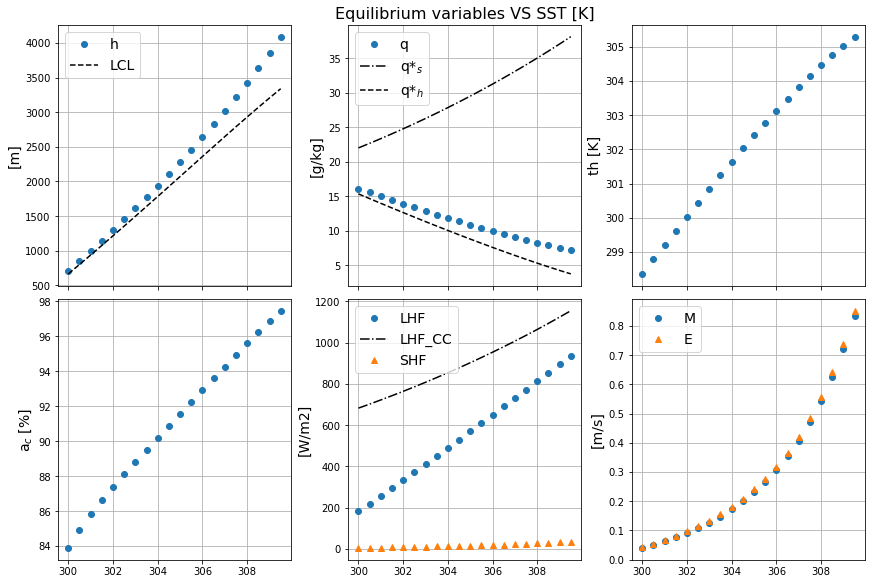

In [83]:
fig, ax = plt.subplots(2,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o',label='h')
ax[0,0].plot(list_of_values,LCL_eq,'--k',label='LCL')
ax[0,0].grid()
ax[0,0].set_ylabel('[m]',fontsize=14)
#ax[0,0].plot(x_N06,h_N06,'kv')
ax[0,0].legend(fontsize=14)

ax[0,1].plot(list_of_values,q_eq*1e3,'o',label='q')
ax[0,1].plot(list_of_values,qs_eq*1e3,'-.k',label='q*$_s$')
ax[0,1].plot(list_of_values,qsat_eq*1e3,'--k',label='q*$_h$')
ax[0,1].grid()
ax[0,1].set_ylabel('[g/kg]',fontsize=14)
#ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
#ax[0,1].plot(x_N06,q_N06,'kv')
ax[0,1].legend(fontsize=14)

ax[0,2].plot(list_of_values,th_eq,'o')
ax[0,2].grid()
ax[0,2].set_ylabel('th [K]',fontsize=14)
#ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
#ax[0,2].legend(fontsize=14)

ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
#ax[1,0].plot(x_N06,a_c_N06,'kv')

ax[1,1].plot(list_of_values,LHF_eq,'o',label='LHF')
ax[1,1].plot(list_of_values,LHF_CC_eq,'-.k',label='LHF_CC')
ax[1,1].plot(list_of_values,SHF_eq,'^',label='SHF')
ax[1,1].grid()
ax[1,1].set_ylabel('[W/m2]',fontsize=14)
ax[1,1].legend(fontsize=14)

ax[1,2].plot(list_of_values,M_eq,'o',label='M')
ax[1,2].plot(list_of_values,E_eq,'^',label='E')
ax[1,2].grid()
ax[1,2].set_ylabel('[m/s]',fontsize=14)
#ax[1,2].plot(x_N06,M_N06,'kv',label='N2006')
ax[1,2].legend(fontsize=14)

ax[0,1].set_title('Equilibrium variables VS '+str_variable+' ['+str_units+']',fontsize=16)

figure_name = 'equilibrium_variables_set2_dependence_on_' + str_variable + '.png'
plt.savefig(figure_name,bbox_inches='tight')

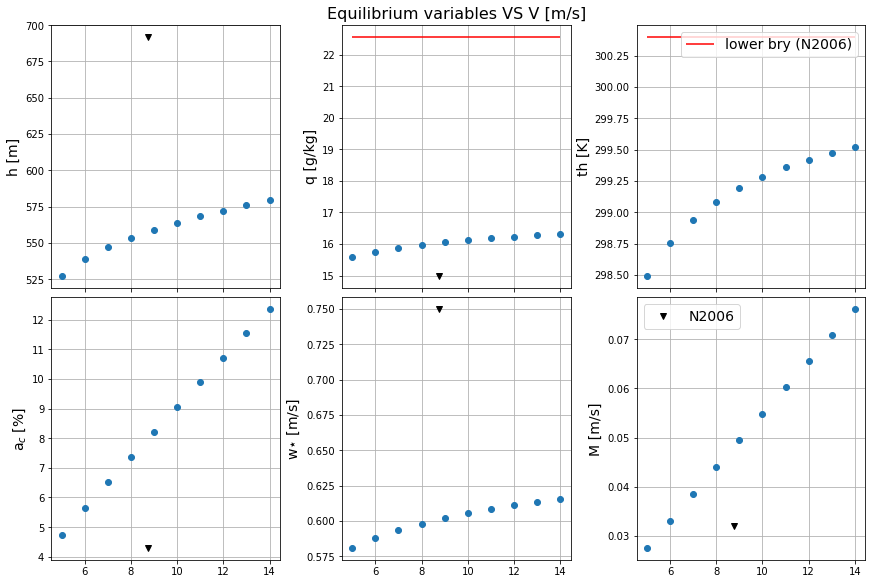

In [36]:
fig, ax = plt.subplots(2,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o')
ax[0,0].grid()
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].plot(x_N06,h_N06,'kv')

ax[0,1].plot(list_of_values,q_eq*1e3,'o')
ax[0,1].grid()
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
ax[0,1].plot(x_N06,q_N06,'kv')

ax[0,2].plot(list_of_values,th_eq,'o')
ax[0,2].grid()
ax[0,2].set_ylabel('th [K]',fontsize=14)
ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)

ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].plot(x_N06,a_c_N06,'kv')

ax[1,1].plot(list_of_values,w_star_eq,'o')
ax[1,1].grid()
ax[1,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[1,1].plot(x_N06,w_star_N06,'kv')

ax[1,2].plot(list_of_values,M_eq,'o')
ax[1,2].grid()
ax[1,2].set_ylabel('M [m/s]',fontsize=14)
ax[1,2].plot(x_N06,M_N06,'kv',label='N2006')
ax[1,2].legend(fontsize=14)

ax[0,1].set_title('Equilibrium variables VS '+str_variable+' ['+str_units+']',fontsize=16)

figure_name = 'equilibrium_variables_dependence_on_' + str_variable + '.png'
plt.savefig(figure_name,bbox_inches='tight')

In [12]:
def prt_dyer74(zL):
    """
    Computation of the turbulent Prandtl number as a function of the nondimensional height z/L (stability)
    following the formulation of Dyer (1974) as in Li, Atmospheric Research (2019) 
    https://doi.org/10.1016/j.atmosres.2018.09.015
    """
    if zL>0:
        return 1
    else:
        return 1/(1-16*zL)**0.25

In [13]:
def neggers_et_al_2006_stevens_et_al_2002(t,y,SST,D,q_free,th_free,ps,f,U_free,V_free,we):
    """
    Subscript s denotes surface values, b stands for buoyancy, which is associated with the virtual potential
    temperature (theta_v), th indicates the liquid water potential temperature (theta_l) and q the total specific
    humidity (q_t).
    A bulk model of the wind speed is added starting from the Stevens et al., JCli (2002) paper
    "Entrainment, Rayleigh friction, and boundary layer winds over the tropical Pacific"
    y[3] is U, the zonal bulk wind component
    y[4] is V, the meridional bulk wind component
    V_mag is the magnitude of the bulk wind = np.sqrt(y[3]**2+y[4]**2)
    """
    # Define some constants.
    delta_z = 100.0 # [m]
    Cqs = 0.0012 # [1], surface exchange coefficient for q
    Cths = 0.0012 # [1], surface exchange coefficient for theta
    Cqc = 0.1 # [1], cloud level exchange coefficient for q
    Cthc = 0.03 # [1], cloud level exchange coefficient for theta
    Le = 2.5e6 # [J/kg], latent heat of vaporization 
    cpd  = 1004.67 # [J/K/kg], dry air specific heat at constant pressure
    Rd = 287.1 # [J/K/kg], dry air gas constant
    # air density is supposed to be constant and equal to 1...
    beta = 0.36
    gamma = 1.55
    g = 9.81 # [m/s2], acceleration due to gravity
    CD = 1/900. # drag coefficient.
    
    ### Define some forcing variables for the BOMEX example -> this will be given as input parameters.
    #V = 8.75 # [m/s], large scale horizontal wind
    #SST = 300.4 # [K], sea surface temperature
    #D = 4.3e-6 # [1/s], large scale divergence
    #q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
    #th_free = 308 # [K], free tropospheric liquid virtual potential temperature
    F_advq = -1.2e-3/86400 # [kg/kg/s]
    F_advth = 0.0/86400 # [K/s]
    F_rad = -2.0/86400 # [K/s]
    #ps = 1015 # [hPa], surface pressure
    ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
    q_s = qsea(SST-273.15,ps)*1e-3 # [kg/kg], surface total specific humidity (saturation value)
    th_s = SST*(ref_p/ps)**(Rd/cpd) # [K], surface liquid water potential temperature, assuming no liquid water at the surface
    
    ### Define some diagnostic variables.
    # Entrainment.
    V_mag = np.sqrt(y[3]**2+y[4]**2) # [m/s], bulk wind speed.
    q_flux_s = V_mag*Cqs*(q_s-y[1]) # total specific humidity flux at the surface
    th_flux_s = V_mag*Cths*(th_s-y[2]) # liquid water potential temperature flux at the surface
    thv_flux_s = (1+0.61*q_s)*th_flux_s + 0.61*th_s*q_flux_s # surface virtual potential temp flux, <w'theta_v'>    # Entrainment.
    delta_q = Cqc*(q_free-y[1])
    delta_th = Cthc*(th_free-y[2])
    delta_thv = delta_th + 0.61*(y[1]*delta_th + y[2]*delta_q + delta_q*delta_th)
    E = 0.2*thv_flux_s/delta_thv
    # Mass flux.
    thv0 = y[2]*(1+0.61*y[1]) # [K], ABL virtual potential temperature
    b_flux_s = g*thv_flux_s/thv0 # surface buoyancy flux
    w_star = (y[0]*b_flux_s)**(1/3) # m/s, Deardorff convective velocity scale. 5th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(ps/ref_p)**(Rd/cpd)*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 4th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 3rd try
#    w_star = (g*y[0]*thv_flux_s/y[2])**(1/3) # m/s, Deardorff convective velocity scale. 2nd try
#    w_star = (g*y[0]*thv_flux_s/th_s)**(1/3) # m/s, Deardorff convective velocity scale. 1st try    
    T0 = y[2]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
    T_h = T0-g/cpd*y[0] # [K], air temperature at h following a dry adiabat.
    p_h = ps*100*(1-g*y[0]/(T0*cpd))**(cpd/Rd) # [Pa], air pressure at h with p=rho*R*T; dp/dz=-rho*g; dtheta/dz=0 
    e_sat_h = qsat(T_h-273.15,p_h/100)*100 # [Pa], saturation vapor pressure at h.
    q_sat = 0.622*e_sat_h/(p_h-0.378*e_sat_h) # [kg/kg], saturation specific humidity at h.   
    sigma_q = np.sqrt(-q_flux_s*delta_q*y[0]/(w_star*delta_z))
    area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)
    M = area_c*w_star
    # Entrainment for the horizontal momentum.
    u_star = V_mag*np.sqrt(CD) # [m/s], Friction velocity, assuming air density equal to 1... We can correct this!
    L = - u_star**3/(0.4*b_flux_s)# [m], Monin-Obukhov length
    print
    zL = 10/L # [1], ratio z/L, we assume z=10 m as a reference height: we are interested in the surface stability
    we_dyn = E*prt_dyer74(zL)
    print(we_dyn)
    
    ### Define the equations to be solved.
    dh_dt = E - D*y[0] - M 
    dq_dt = (q_flux_s + E*delta_q)/y[0] + F_advq
    dth_dt = (th_flux_s + E*delta_th)/y[0] + F_advth + F_rad
    dU_dt = f*(y[4]-V_free)-y[3]*(CD*V_mag+we_dyn)/y[0]+U_free*we_dyn/y[0]
    dV_dt = -f*(y[3]-U_free)-y[4]*(CD*V_mag+we_dyn)/y[0]+V_free*we_dyn/y[0]
    
    #print(area_c)
    #print((y[1]-q_sat)*1e3)
    #print(sigma_q*1e3)
    #print(w_star)
    #print((y[1]-q_sat)/sigma_q)
    area_c_ext.append(area_c)
    w_star_ext.append(w_star)
    M_ext.append(M)
    E_ext.append(E)
    sigma_q_ext.append(sigma_q)
    LHF_ext.append(q_flux_s*Le)
    
    return dh_dt, dq_dt, dth_dt, dU_dt, dV_dt

In [20]:
# Compute the wind components (to be used as free tropospheric wind) starting from the surface wind used in 
# Neggers et al (2006).
magnitude = 8.75 # [m/s]
angle = 67.5 # [°] clockwise from north
windu = magnitude*np.sin(angle*np.pi/180)
windv = magnitude*np.cos(angle*np.pi/180)
print(windu)
print(windv)

8.083945909473758
3.348480033194536


In [38]:
Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)
U_free = -windu # [m/s], free zonal wind (above the ABL).
V_free = -windv # [m/s], free meridional wind (above the ABL).
we = 0.01 # [m/s], entrainment velocity for the horizontal velocity.

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2,U_free,V_free]

# Input parameters
#V = 8.75 # [m/s], large scale horizontal wind -> no longer needed!
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
ps = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0
area_c_ext = []
w_star_ext = []
M_ext = []
E_ext = []
sigma_q_ext = []
LHF_ext = []
sol = solve_ivp(neggers_et_al_2006_stevens_et_al_2002, time, y0, dense_output=True, max_step=dt_max, args=(SST,D,q_free,th_free,ps,f,U_free,V_free,we))#, t_eval=t_eval)

<ipython-input-13-7c1331a09213>:65: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


0.022377001961311423
0.022368686956280467
0.022376855282642695
0.02237678188554605
0.022376416099083227
0.022376353119687196
0.02237627190867568
0.02237626857668865
0.022375759815451864
0.022375505594004832
0.02237423467380926
0.022374008825773197
0.02237372655636128
0.022373726557190977
0.02236864627111615
0.0223661219783769
0.02235351850124366
0.022351286730556356
0.022348501479057325
0.02234850206386956
0.022322203105824067
0.022309477237290896
0.022246258395679657
0.02223520916580541
0.022221558476620266
0.02222162516729803
0.022197146687448384
0.0221852846217239
0.022126346449737745
0.022116043264455175
0.02210330093153282
0.022103352667457447
0.022080500070151752
0.022069411627068936
0.022014306491625196
0.022004669101630188
0.02199274221873636
0.021992785543507094
0.021971392753425495
0.021961000445084606
0.02190934516680379
0.021900307062171245
0.021889115536056495
0.02188915240429624
0.021869076259269538
0.02185931304494059
0.021810776145358788
0.02180227995925265
0.0217917542

0.019039161021371445
0.0190391338867903
0.019039133901856863
0.019039085244475937
0.019039061480413292
0.01903894350453082
0.019038922877770443
0.01903889726024525
0.01903889727520492
0.019038851347109594
0.01903882894259176
0.019038717758084085
0.019038698335702146
0.019038674222254883
0.019038674237108377
0.019038631014958524
0.01903860995838406
0.019038505507334456
0.01903848727907568
0.01903846465690572
0.0190384646716536
0.019038424132427633
0.019038404412353417
0.019038306637634804
0.01903828959338391
0.019038268449864927
0.019038268464507874
0.019038230585497928
0.01903821219063675
0.019038121035900222
0.0190381051656795
0.019038085488357177
0.01903808550289572
0.01903805026170315
0.01903803318092131
0.019037948590584466
0.019037933884552157
0.019037915661141356
0.019037915675576073
0.019037883050106695
0.01903786727242185
0.019037789191657654
0.019037775640105493
0.019037758858488206
0.01903775887281953
0.01903772884127925
0.01903771435585815
0.019037642730584056
0.019037630323

0.019297591096698426
0.019297772539375053
0.01929868020633388
0.01929884171158014
0.019299043656097855
0.019299043658132432
0.0192994072550338
0.019299589246131617
0.01930049965516768
0.01930066164776838
0.01930086420142312
0.019300864203455798
0.019301228896792946
0.019301411435825627
0.019302324584508604
0.01930248706403167
0.019302690226283736
0.01930269022831457
0.019303056017115912
0.01930323910359809
0.01930415498950089
0.01930431795551511
0.01930452172582545
0.019304521727854435
0.019304888611149835
0.019305072244596655
0.01930599086529568
0.019306154317370258
0.01930635869520058
0.019306358697227827
0.01930672667404845
0.01930691085397579
0.019307832207050606
0.019307996144755465
0.019308201129568138
0.01930820113159369
0.019308570200972017
0.019308754926896318
0.019309679009929654
0.019309843432835195
0.01931004902409333
0.019310049026117188
0.01931041918708687
0.019310604458525223
0.019311531269102917
0.01931169617678002
0.019311902373947427
0.019311902375969654
0.01931227362

0.020030504025688987
0.020030788487053024
0.020031144111371215
0.02003114411318221
0.02003178433174829
0.020032104552744002
0.020033706108913304
0.020033990936640513
0.020034347018860275
0.02003434702067026
0.020034988063456726
0.02003530869628068
0.020036912311604902
0.020037197505283575
0.020037554044890174
0.02003755404669917
0.020038195912779562
0.02003851695696862
0.02004012262913223
0.020040408188350664
0.020040765184829626
0.020040765186637617
0.020041407875085848
0.020041729330177102
0.02004333705686541
0.02004362298121229
0.02004398043404928
0.020043980435856205
0.020044623945746683
0.020044945811277283
0.020046555590176738
0.02004684187924066
0.020047199787921684
0.020047199789727677
0.02004784412013515
0.020048166395642556
0.02004977822444044
0.020050064877810424
0.020050423241821613
0.020050423243626582
0.02005106839362626
0.020051391078648055
0.020053004955032733
0.0200532919722979
0.02005365079112564
0.02005365079292954
0.020054296761596913
0.020054619855670988
0.02005623

0.021077744466632787
0.021078163194850334
0.021080257301557874
0.0210806296630143
0.021081095148833575
0.02108109515026376
0.0210819331211182
0.021082352142496905
0.021084447715096703
0.021084820337059253
0.021085286148468073
0.021085286149896635
0.021086124706825457
0.02108654402099095
0.02108864105761184
0.021089013939748054
0.021089480076330692
0.02108948007775758
0.02109031922001265
0.02109073882659099
0.021092837325363416
0.021093210467340938
0.021093676928682085
0.0210936769301074
0.021094516656941162
0.02109493655555881
0.02109703651461485
0.02109740991610171
0.02109787670178651
0.0210978767032102
0.021098717013875796
0.021099137204159468
0.021101238621632996
0.021101612282297535
0.02110207939191136
0.02110207939333341
0.02110292028708474
0.021103340768661414
0.021105443642687925
0.02110581756219873
0.0211062849953274
0.021106284996747802
0.021107126472839313
0.021107547245336433
0.021109651574053093
0.021110025752079115
0.02111049350830879
0.02111049350972757
0.0211113355674144

0.02238685758947605
0.022389300650566112
0.02238973502296041
0.022390278011044182
0.02239027801198204
0.02239125549083041
0.022391744199822802
0.022394188235451733
0.022394622781011397
0.022395165985513072
0.02239516598644915
0.022396143854857154
0.022396632758412967
0.022399077766914473
0.02239951248534315
0.022400055905892367
0.022400055906826703
0.022401034164127556
0.022401523261913567
0.022403969241620598
0.022404404132621892
0.022404947768848115
0.0224049477697807
0.02240592641530744
0.022406415706990108
0.022408862656235002
0.022409297719512444
0.02240984157104497
0.022409841571975866
0.02241082060506119
0.022411310090306988
0.022413758007421337
0.022414193242678262
0.022414737309146334
0.02241473731007549
0.022415716730051834
0.02241620640852706
0.022418655291841845
0.022419090698781462
0.022419634979814168
0.022419634980741524
0.022420614786941035
0.022421104658311868
0.022423554506157236
0.022423990084482735
0.022424534579708895
0.02242453458063451
0.022425514772389122
0.0224

0.02369020905433582
0.023690209054829745
0.02369126282458065
0.023691789624697906
0.023694424107346103
0.023694892485594046
0.02369547796996179
0.023695477970453942
0.023696531939835418
0.02369705883955446
0.023699693820062144
0.023700162286706825
0.023700747881520788
0.023700747882011174
0.023701802050161043
0.023702329049050865
0.02370496452526173
0.023705433079919586
0.023706018784700366
0.023706018785188954
0.02370707315124404
0.02370760024887304
0.02371023621862775
0.023710704860914783
0.023711290675182278
0.023711290675669097
0.02371234523876502
0.023712872434700927
0.023715508895837442
0.023715977625369176
0.023716563548642607
0.02371656354912771
0.023717618308398962
0.023718145602209022
0.0237207825525624
0.02372125136895373
0.02372183740075184
0.023721837401235103
0.023722892355815015
0.023723419747065908
0.0237260571844683
0.023726526087333763
0.02372711222717448
0.023727112227656014
0.023728167376676778
0.023728694864934546
0.023731332787215256
0.023731801776168782
0.0237323

0.025148757703939106
0.02514923430837225
0.0251498300596575
0.025149830059636363
0.025150902491460157
0.025151438564552788
0.025154119329336106
0.02515459589966917
0.025155191608264096
0.02515519160824097
0.02515626396312522
0.02515679999754278
0.025159480568497178
0.02515995710422404
0.025160552769495984
0.025160552769470778
0.025161625046276427
0.02516216104144958
0.02516484141572697
0.025165317916341304
0.02516591353765714
0.02516591353762993
0.025166985735217366
0.02516752169057641
0.025170201865327414
0.025170678330322518
0.025171273907049027
0.025171273907019762
0.025172346024248792
0.025172881939223717
0.025175561911597536
0.025176038340466594
0.025176633871970094
0.025176633871938824
0.02517770590766871
0.025178241781689256
0.02518092154883377
0.025181397941069536
0.025181993426716124
0.025181993426682783
0.0251830653797722
0.025183601212267932
0.025186280771329464
0.025186757126424673
0.025187352565580034
0.025187352565544677
0.02518842443485181
0.025188960225251886
0.02519163

0.026594896193755206
0.02659489619315783
0.02659590365386681
0.02659640719316697
0.026598925135945195
0.026599372719431844
0.026599932176452658
0.026599932175853234
0.026600939245539586
0.026601442589197846
0.026603959553152253
0.026604406962489734
0.02660496620176375
0.026604966201162296
0.026605972878775776
0.026606476026267336
0.026608992008774267
0.026609439243496277
0.02660999826444075
0.026609998263837267
0.026611004548328862
0.026611507499129668
0.026614022497568533
0.026614469557209395
0.02661502835924222
0.02661502835863673
0.02661603424895872
0.02661653700254531
0.026619051014298713
0.02661949789839325
0.026620056480933105
0.026620056480325564
0.026621061975431477
0.026621564531281065
0.026624077553734884
0.026624524261818574
0.026625082624284747
0.026625082623675196
0.026626087722519894
0.02662659008011025
0.02662910211065354
0.026629548642262323
0.026630106784074934
0.02663010678346341
0.026631111485003026
0.026631613643812606
0.02663412467983763
0.026634571034508156
0.0266

0.027656176817285338
0.02765707454445147
0.027657523199063186
0.027659766585998356
0.027660165334671537
0.027660663737115922
0.027660663736123643
0.027661560880030973
0.02766200924298603
0.027664251171085605
0.0276646496603271
0.027665147738444723
0.027665147737451
0.027666044297456158
0.027666492368433375
0.027668732836092058
0.027669131065616664
0.027669628819051256
0.027669628818056104
0.027670524793518
0.027670972572197295
0.02767321157781528
0.027673609547338926
0.027674106975735458
0.027674106974738908
0.027675002365018613
0.027675449851081006
0.02767768739306419
0.027678085102303806
0.027678582205308493
0.027678582204310506
0.027679477008771353
0.027679924201899034
0.027682160278658774
0.027682557727332222
0.02768305450459255
0.027683054503593207
0.027683948721600828
0.027684395621477044
0.027686630231430455
0.027687027419256584
0.027687523870421345
0.027687523869420524
0.027688417500342732
0.02768886410665198
0.02769109724822173
0.027691494174920357
0.02769199029963946
0.027691

0.02875809846627284
0.02875846008251246
0.0287602681555386
0.02876058950333286
0.02876099114940838
0.028760991148184933
0.02876171410573208
0.028762075384947197
0.02876388177251592
0.028764202820668588
0.02876460409219001
0.02876460409096631
0.02876532637424883
0.028765687316421415
0.028767492018443072
0.028767812766938697
0.028768213663886478
0.02876821366266247
0.02876893527164552
0.02876929587675855
0.028771098893148626
0.028771419341972308
0.028771819864328165
0.028771819863103912
0.02877254079775466
0.028772901065791966
0.028774702396471043
0.028775022545608885
0.0287754226933555
0.028775422692131056
0.028776142952418714
0.028776502883365168
0.02877830252825865
0.028778622377697686
0.028779022150819053
0.02877902214959433
0.028779741735490024
0.028780101329331623
0.028781899288369973
0.028782218838098103
0.028782618236579186
0.028782618235354208
0.02878333714683113
0.02878369640355478
0.02878549267667335
0.0287858119266794
0.028786210950506277
0.028786210949281018
0.02878692918631

0.02959686579342488
0.029597140495479613
0.02959851393804386
0.02959875802457521
0.029599063096855872
0.029599063095689
0.029599612208785982
0.029599886598352207
0.02960125847834887
0.02960150228713763
0.0296018070122608
0.029601807011094557
0.029602355499285183
0.029602629576544942
0.02960399989488445
0.029604243426092643
0.02960454780426103
0.02960454780309538
0.02960509566674438
0.029605369431880125
0.02960673818947547
0.029606981443265443
0.029607285474682037
0.02960728547351705
0.029607832712990112
0.029608106166184825
0.029609473363951342
0.029609716340486057
0.029610020025354476
0.0296100200241901
0.02961056663985396
0.029610839781290976
0.029612205420146642
0.02961244811958935
0.02961275145811385
0.02961275145695005
0.029613297449172384
0.029613570279035682
0.02961493435990073
0.029615176782415122
0.029615479774800512
0.02961547977363729
0.029616025142786682
0.02961629766126069
0.02961766018505781
0.0296179023308081
0.0296182049772595
0.029618204976096914
0.02961874972254298
0.

0.030195589331606876
0.03019579203097348
0.030196805445842273
0.030196985542113565
0.030197210633061116
0.03019721063210237
0.03019761577658475
0.03019781822001917
0.03019883035522608
0.03019901022406651
0.03019923503075416
0.030199235029796417
0.030199639662613652
0.030199841850365162
0.030200852707157055
0.030201032348788365
0.03020125687149335
0.03020125687053658
0.030201660992187518
0.030201862924505548
0.030202872504129803
0.030203051918773774
0.030203276157773143
0.030203276156817324
0.03020367976780104
0.030203881444935094
0.030204889748639264
0.030205068936517684
0.03020529289208882
0.03020529289113398
0.030205695991949673
0.0302058974141491
0.03020690444318126
0.030207083404516003
0.030207307076936325
0.030207307075982383
0.030207709667129292
0.030207910834643904
0.03020891659025225
0.030209095325265223
0.030209318714812052
0.030209318713859096
0.030209720795836708
0.03020992170891606
0.0302109261923493
0.030211104701262523
0.030211327808213343
0.03021132780726139
0.0302117293

0.030636295398706565
0.030636440911980835
0.030637168404175567
0.03063729768606602
0.03063745926627929
0.030637459265567914
0.030637750092986773
0.030637895413284152
0.03063862194064713
0.030638751051072916
0.03063891241698232
0.03063891241627179
0.03063920285795671
0.03063934798551241
0.030640073549219052
0.030640202488389078
0.030640363640255738
0.030640363639546163
0.03064065369596731
0.030640798631016198
0.03064152323224127
0.030641652000364276
0.030641812938449264
0.030641812937740626
0.030642102609367887
0.030642247352144682
0.030642970992062153
0.030643099589346832
0.03064326031391092
0.03064326031320332
0.03064354960050604
0.030643694151245425
0.03064441683102857
0.030644545257683474
0.030644705768987444
0.03064470576828065
0.03064499467172815
0.0306451390306646
0.030645860751486016
0.030645989007719567
0.03064614930602367
0.03064614930531782
0.03064643782537897
0.03064658199274681
0.03064730275577811
0.030647430841798533
0.030647590927363196
0.030647590926658266
0.030647879063

0.030937320647528653
0.030937425915259113
0.03093795219413142
0.030938045718169997
0.030938162607020744
0.030938162606515305
0.030938372992933578
0.03093847811941063
0.03093900369207788
0.030939097090618293
0.030939213822617908
0.030939213822113242
0.030939423926214203
0.0309395289116278
0.03094005377903985
0.030940147052250722
0.030940263627610317
0.03094026362710644
0.03094047344926987
0.030940578293809667
0.03094110245691536
0.03094119560496531
0.030941312023895655
0.030941312023392453
0.03094152156399764
0.030941626267853288
0.0309421497276004
0.03094224275065787
0.03094235901336932
0.03094235901286694
0.030942568272292855
0.030942672835653724
0.030943195592988887
0.030943288491222132
0.030943404597925182
0.030943404597423462
0.030943613576048627
0.03094371799910377
0.030944240054972726
0.03094433282854981
0.03094444877945444
0.03094444877895354
0.03094465747715611
0.030944761760094506
0.03094528311544178
0.030945375764530728
0.03094549155984675
0.03094549155934657
0.03094569997750

0.03114232426037442
0.031142393459715798
0.031142479947020393
0.031142479946663307
0.031142635613399704
0.031142713398542816
0.031143102277962714
0.031143171385216526
0.031143257757428457
0.031143257757071975
0.03114341321665427
0.03114349089829031
0.031143879260230493
0.03114394827552545
0.03114403453280532
0.031144034532449415
0.031144189785166684
0.03114426736344019
0.031144655208623168
0.031144724132087583
0.03114481027459584
0.031144810274240483
0.03114496532038164
0.031145042795436853
0.031145430124584005
0.03114549895634607
0.031145584984243028
0.03114558498388821
0.03114573982374166
0.031145817195722653
0.031146204009554545
0.03114627274974223
0.03114635866318792
0.03114635866283369
0.031146513296687422
0.031146590565738166
0.031146976864974286
0.03114704551371557
0.031147131312869693
0.03114713131251608
0.03114728574065776
0.031147362906921997
0.031147748692280926
0.031147817249703544
0.03114790293472575
0.031147902934372588
0.031148057157089567
0.03114813422071077
0.031148519

0.031317556215301065
0.031317665713579544
0.03131772042995442
0.03131799397867547
0.03131804259107855
0.03131810334844331
0.031318103348210904
0.03131821270405328
0.03131826734925703
0.03131854054216563
0.03131858909133888
0.031318649769677964
0.03131864976944595
0.03131875898305159
0.03131881355718406
0.03131908639477801
0.03131913488081013
0.03131919548023411
0.031319195480002435
0.031319304551570455
0.03131935905473091
0.03131963153750771
0.03131967996048696
0.03131974048110635
0.031319740480875054
0.03131984941060428
0.031319903842892224
0.03132017597134843
0.03132022433136314
0.03132028477328803
0.031320284773057185
0.03132039356114615
0.0313204479226606
0.031320719697292235
0.03132076799443036
0.03132082835777112
0.03132082835754059
0.03132093700418746
0.03132099129502772
0.03132126271632972
0.031321310950679415
0.03132137123554596
0.03132137123531583
0.03132147974071863
0.03132153396098335
0.031321805029450395
0.03132185320109945
0.03132191340760151
0.03132191340737181
0.0313220

0.031440163020349764
0.03144035791344076
0.03144039254828191
0.031440435836199127
0.031440435836046714
0.031440513749042956
0.03144055268302548
0.03144074732941247
0.031440781920412816
0.03144082515353647
0.031440825153384346
0.0314409029677592
0.03144094185246241
0.03144113625248321
0.03144117079970264
0.03144121397810782
0.031441213977956
0.031441291693844554
0.03144133052933574
0.0314415246833276
0.03144155918682598
0.0314416023105876
0.031441602310435926
0.031441679927972956
0.03144171871431965
0.03144191262261904
0.03144194708245612
0.03144199015164915
0.03144199015149777
0.03144206767081775
0.03144210640808705
0.03144230007103029
0.03144233448726598
0.0314423775019648
0.03144237750181358
0.03144245492305091
0.031442493611310136
0.03144268702923281
0.031442721401926645
0.03144276436220585
0.03144276436205497
0.03144284168534383
0.03144288032465999
0.03144307349789716
0.03144310782710884
0.03144315073304281
0.03144315073289215
0.03144322795836667
0.03144326654880652
0.0314434594776

0.03152749356655864
0.03152763384629809
0.03152765877592127
0.03152768993400305
0.03152768993390167
0.031527746014712206
0.03152777403939566
0.031527914146057934
0.03152793904492381
0.03152797016456412
0.031527970164462966
0.03152802617608368
0.03152805416619317
0.031528194100007505
0.031528218968156684
0.03152825004940642
0.0315282500493054
0.031528305991827835
0.03152833394740929
0.031528473708604295
0.03152849854607761
0.031528529588987456
0.031528529588886654
0.03152858546240222
0.03152861338350132
0.0315287529723056
0.031528777779143445
0.03152880878376426
0.03152880878366359
0.03152886458826367
0.03152889247492594
0.03152903189156753
0.03152905666781048
0.031529087634193015
0.03152908763409244
0.03152914336986828
0.03152917122213928
0.03152931046684599
0.03152933521253452
0.03152936614072932
0.031529366140629
0.03152942180767159
0.03152944962559683
0.03152958869859616
0.03152961341377074
0.03152964430382818
0.031529644303727906
0.03152969990212817
0.03152972768575315
0.0315298665

0.03159036459119428
0.03159038496771998
0.03159048683830727
0.031590504942234844
0.031590527569340936
0.03159052756927225
0.03159056829538398
0.031590588647294776
0.03159069039482309
0.03159070847688176
0.03159073107665527
0.03159073107658659
0.03159077175350292
0.03159079208083041
0.03159089370545709
0.03159091176567467
0.03159093433815049
0.03159093433808191
0.0315909749658658
0.031590995268641404
0.031591096770523436
0.031591114808927956
0.03159113735414096
0.03159113735407251
0.031591177932786776
0.031591198211041824
0.03159129959033622
0.03159131760695548
0.03159134012494058
0.031591340124872164
0.03159138065457946
0.031591400908345314
0.03159150216520886
0.03159152016007069
0.03159154265086266
0.03159154265079438
0.03159158313155736
0.03159160336086533
0.0315917044954543
0.03159172246858663
0.031591744932220236
0.03159174493215207
0.031591785364033266
0.03159180556891455
0.03159190658138538
0.03159192453281588
0.03159194696932587
0.03159194696925775
0.03159198735231954
0.03159200

0.031633466601458236
0.03163348180849296
0.031633557834763425
0.031633571345839336
0.0316335882326249
0.03163358823257616
0.03163361862681042
0.031633633815748685
0.03163370975154877
0.03163372324654682
0.03163374011323783
0.03163374011318912
0.03163377047125541
0.03163378564211995
0.03163386148756199
0.03163387496650224
0.03163389181312358
0.03163389181307487
0.03163392213501805
0.03163393728783137
0.03163401304302762
0.03163402650593009
0.03163404333250653
0.03163404333245791
0.031634073618322975
0.031634088753107276
0.03163416441816994
0.03163417786505445
0.03163419467161099
0.03163419467156245
0.03163422492139404
0.03163424003817198
0.03163431561321292
0.03163432904409926
0.03163434583066095
0.031634345830612386
0.03163437604445541
0.03163439114324919
0.03163446662838023
0.031634480043288456
0.031634496809879876
0.03163449680983141
0.03163452698773051
0.031634542068562505
0.03163461746389526
0.03163463086284509
0.03163464760949123
0.03163464760944285
0.03163467775144267
0.031634692

0.03166443281112746
0.03166444435141367
0.031664502046134836
0.031664512299439763
0.031664525114525346
0.031664525114489604
0.03166454818015173
0.031664559706847985
0.03166461733362638
0.031664627574856975
0.03166464037485149
0.03166464037481575
0.03166466341331575
0.03166467492643831
0.03166473248535678
0.03166474271452759
0.031664755499449214
0.031664755499413624
0.03166477851078442
0.0316647900103499
0.03166484750149078
0.03166485771861654
0.03166487048848377
0.03166487048844814
0.03166489347272272
0.03166490495874753
0.03166496238219314
0.03166497258728846
0.03166498534211962
0.031664985342084014
0.031665008299295264
0.031665019771795866
0.031665077127628526
0.031665087320708045
0.031665100060521194
0.03166510006048571
0.03166512299066649
0.03166513444965941
0.03166519173796119
0.03166520191903946
0.031665214643852996
0.03166521464381751
0.03166523754700084
0.0316652489925022
0.03166530621335525
0.03166531638244687
0.03166532909227897
0.03166532909224344
0.03166535196846192
0.03166

0.03169035383118488
0.03169036327695481
0.031690363276929284
0.03169038027822155
0.031690388774385715
0.03169043125029206
0.031690438798982735
0.03169044823371773
0.03169044823369211
0.03169046521512279
0.0316904737013615
0.031690516127646354
0.031690523667518455
0.0316905330912316
0.03169053309120607
0.03169055005279868
0.0316905585291238
0.03169060090584638
0.03169060843691053
0.03169061784961495
0.0316906178495894
0.031690634791367786
0.031690643257791085
0.03169068558501047
0.03169069310727703
0.03169070250898596
0.03169070250896053
0.03169071943094821
0.03169072788748155
0.031690770165256725
0.03169077767873624
0.03169078706946271
0.03169078706943733
0.03169080397165785
0.031690812418313084
0.03169085464670294
0.031690862151405964
0.03169087153116318
0.03169087153113784
0.031690888413614934
0.03169089685040368
0.03169093902946718
0.031690946525404065
0.03169095589420512
0.03169095589417969
0.03169097275693679
0.031690981183870925
0.03169102331366695
0.03169103080084827
0.031691040

0.031708915694796634
0.0317089227360036
0.03170892273598482
0.03170893540934472
0.03170894174270228
0.031708973405837594
0.03170897903292427
0.03170898606594609
0.03170898606592735
0.03170899872455475
0.031709005050550174
0.03170903667687821
0.03170904229742374
0.031709049322269936
0.031709049322251215
0.0317090619661636
0.031709068284805346
0.031709099874369685
0.031709105488381586
0.031709112505061844
0.03170911250504318
0.03170912513425791
0.03170913144555468
0.03170916299839852
0.031709168605884575
0.03170917561440855
0.03170917561438989
0.03170918822892417
0.03170919453288457
0.031709226049051284
0.03170923165001928
0.0317092386503964
0.031709238650377794
0.031709251250248975
0.03170925754688176
0.03170928902641435
0.031709294620871804
0.031709301613112
0.03170930161309342
0.031709314198318725
0.031709320487632406
0.031709351930574156
0.03170935751852877
0.031709364502641404
0.03170936450262287
0.03170937707321946
0.031709383355222893
0.03170941476161672
0.031709420343076236
0.031

0.03172257626592934
0.031722585767988434
0.03172259051653554
0.03172261425653689
0.0317226184755499
0.03172262374869085
0.03172262374867697
0.031722633239723144
0.03172263798276684
0.03172266169525377
0.03172266590937705
0.031722671176406425
0.0317226711763926
0.03172268065643887
0.03172268539398534
0.03172270907899015
0.03172271328822923
0.03172271854915442
0.03172271854914057
0.03172272801819977
0.031722732750255535
0.03172275640781018
0.03172276061217097
0.031722765866998924
0.03172276586698513
0.03172277532507001
0.03172278005164156
0.031722803681778156
0.0317228078812662
0.031722813130003996
0.03172281312999025
0.03172282257711357
0.03172282729820738
0.03172285090095789
0.03172285509557898
0.031722860338233905
0.03172286033822002
0.031722869774394716
0.031722874490017094
0.031722898065413535
0.03172290225517335
0.03172290749175232
0.031722907491738575
0.03172291691697747
0.03172292162713463
0.03172294517520891
0.03172294936011326
0.03172295459062351
0.03172295459060968
0.031722964

0.03173284529917341
0.031732848464570376
0.03173285242084817
0.03173285242083788
0.03173285954168258
0.031732863100248525
0.031732880891030345
0.03173288405276493
0.03173288800446544
0.031732888004455236
0.03173289511706126
0.03173289867150995
0.03173291644170832
0.031732919599784984
0.03173292354691345
0.03173292354690311
0.031732930651280106
0.031732934201616395
0.03173295195125522
0.03173295510567799
0.03173295904823984
0.03173295904822951
0.031732966144386934
0.03173296969061561
0.03173298741971879
0.031732990570491976
0.031732994508492415
0.031732994508482076
0.031733001596429555
0.03173300513855548
0.0317330228471468
0.031733025994274716
0.031733029927718925
0.03173302992770873
0.03173303700745585
0.031733040545483565
0.03173305823358685
0.031733061377073726
0.0317330653059673
0.03173306530595704
0.031733072377513175
0.03173307591144771
0.031733093579086866
0.03173309671893684
0.03173310064328483
0.03173310064327455
0.03173310770664924
0.03173311123649521
0.03173312888369391
0.03

0.03174082028168877
0.031740820281681126
0.03174082555865929
0.0317408281957741
0.03174084137983178
0.031740843722871295
0.03174084665132425
0.03174084665131662
0.031740851922195217
0.03174085455626195
0.03174086772508026
0.03174087006541142
0.03174087299047952
0.031740872990471874
0.03174087825525791
0.031740880886279986
0.031740894039876684
0.031740896377502666
0.031740899299189745
0.03174089929918213
0.0317409045578827
0.031740907185863525
0.031740920324256336
0.031740922659180305
0.031740925577490246
0.03174092557748265
0.03174093083010475
0.031740933455048005
0.03174094657825438
0.031740948910479516
0.03174095182541625
0.03174095182540865
0.03174095707195934
0.03174095969386856
0.031740972801906055
0.0317409751314355
0.03174097804300292
0.03174097804299535
0.03174098328348173
0.03174098590236026
0.031740998995246676
0.031741001322083344
0.03174100423028542
0.03174100423027784
0.03174100946470689
0.031741012080558385
0.031741025158311065
0.03174102748245826
0.03174103038729884
0.03

0.031746592067993996
0.03174659403851989
0.03174660389001528
0.03174660564079997
0.031746607829022264
0.031746607829016546
0.03174661176756467
0.03174661373581376
0.03174662357592654
0.031746625324688305
0.03174662751038213
0.03174662751037644
0.03174663144437381
0.031746633410348654
0.03174664323909198
0.03174664498583315
0.03174664716900152
0.031746647168995876
0.031746651098447785
0.03174665306215119
0.03174666287953796
0.03174666462426088
0.03174666680490679
0.031746666804901146
0.03174667072981288
0.03174667269124725
0.03174668249729087
0.031746684239997824
0.031746686418124254
0.031746686418118605
0.03174669033849546
0.03174669229766355
0.03174670209237696
0.03174670383307037
0.03174670600868
0.03174670600867438
0.031746709924521416
0.031746711881425894
0.031746721664822224
0.03174672340350436
0.03174672557660039
0.03174672557659477
0.031746729487917354
0.031746731442560794
0.03174674121465308
0.03174674295132642
0.031746745121911446
0.03174674512190581
0.03174674902870919
0.0317

0.03175110278805312
0.03175110568734434
0.03175110713623564
0.03175111437985791
0.03175111566717752
0.031751117276136845
0.031751117276132716
0.031751120172074355
0.03175112161929161
0.03175112885454515
0.03175113014037752
0.03175113174747807
0.03175113174747376
0.03175113464006963
0.031751136085614945
0.031751143312509396
0.03175114459685621
0.031751146202099956
0.03175114620209586
0.031751149091349774
0.03175115053522506
0.031751157753770166
0.03175115903663304
0.031751160640022306
0.03175116064001811
0.03175116352593409
0.031751164968141066
0.03175117217834649
0.03175117345972732
0.03175117506126399
0.03175117506125989
0.03175117794384171
0.03175117938438253
0.031751186586257814
0.031751187866158215
0.031751189465844584
0.03175118946584045
0.03175119234509189
0.03175119378396849
0.03175120097752323
0.03175120225594492
0.031751203853783265
0.03175120385377906
0.0317512067297041
0.031751208166918246
0.03175121535216215
0.03175121662910677
0.03175121822509914
0.031751218225094885
0.031

0.03175416514331834
0.03175416623863217
0.03175417171457056
0.03175417268774155
0.03175417390406145
0.031754173904058276
0.03175417609329401
0.031754177187342324
0.03175418265695378
0.031754183629000315
0.031754184843914846
0.0317541848439117
0.03175418703061801
0.03175418812340222
0.03175419358669396
0.031754194557617445
0.031754195771128216
0.03175419577112513
0.03175419795530493
0.0317541990468265
0.03175420450380599
0.03175420547360763
0.03175420668571633
0.03175420668571312
0.03175420886736922
0.03175420995762974
0.03175421540830417
0.03175421637698526
0.03175421758769353
0.03175421758769038
0.03175421976682584
0.031754220855826513
0.03175422630020328
0.03175422726776504
0.0317542284770745
0.03175422847707133
0.03175423065368898
0.03175423174143148
0.03175423717951764
0.031754238145961525
0.03175423935387369
0.03175423935387051
0.03175424152797332
0.031754242614459
0.0317542480462619
0.03175424901158925
0.03175425021810574
0.03175425021810259
0.031754252389693344
0.031754253474923

0.03175650276352101
0.03175650358864848
0.031756507713810694
0.031756508446924785
0.03175650936320912
0.03175650936320672
0.03175651101241297
0.03175651183658694
0.03175651595698208
0.03175651668924899
0.0317565176044745
0.03175651760447213
0.03175651925177254
0.031756520074994056
0.0317565241906279
0.03175652492204867
0.03175652583621643
0.03175652583621406
0.031756527481610904
0.0317565283038812
0.03175653241475906
0.0317565331453345
0.03175653405844595
0.0317565340584437
0.031756535701939176
0.03175653652325924
0.03175654062938655
0.03175654135911791
0.031756542271174165
0.03175654227117176
0.03175654391276807
0.03175654473313904
0.031756548834521454
0.03175654956340947
0.03175655047441184
0.031756550474409485
0.03175655211410876
0.031756552933531794
0.03175655703017466
0.03175655775822041
0.03175655866816991
0.031756558668167574
0.031756560305972056
0.03175656112444807
0.031756565216357
0.031756565943561355
0.03175656685245946
0.0317565668524571
0.0317565684883689
0.031756569305899

0.03175844463445828
0.031758445168491904
0.031758445835955024
0.031758445835953254
0.03175844703731003
0.03175844763767581
0.031758450639158636
0.03175845117257494
0.031758451839266635
0.031758451839265005
0.03175845303923325
0.03175845363890508
0.03175845663691865
0.03175845716971855
0.03175845783563973
0.03175845783563796
0.03175845903421924
0.03175845963319796
0.03175846262774652
0.03175846315993064
0.0317584638250821
0.03175846382508032
0.031758465022276236
0.03175846562056273
0.03175846861165002
0.031758469143219156
0.03175846980760171
0.03175846980760007
0.031758471003412315
0.031758471601007233
0.03175847458863753
0.03175847511959203
0.03175847578320685
0.03175847578320505
0.031758476977635224
0.03175847757453936
0.03175848055871648
0.031758481089057364
0.03175848175190511
0.031758481751903454
0.03175848294495307
0.03175848354116734
0.031758486521895404
0.03175848705162321
0.03175848771370491
0.031758487713703154
0.0317584889053738
0.03175848950089902
0.03175849247818181
0.03175

0.03175965061514342
0.031759651076347574
0.03175965338210234
0.03175965379187561
0.03175965430403166
0.03175965430403024
0.03175965522585204
0.031759655686523024
0.031759657989612305
0.03175965839891189
0.031759658910475816
0.0317596589104745
0.03175965983123065
0.0317596602913691
0.031759662591795995
0.03175966300062249
0.031759663511595065
0.03175966351159376
0.031759664431285584
0.03175966489089203
0.03175966718865972
0.03175966759701345
0.03175966810739541
0.03175966810739407
0.03175966902602271
0.03175966948509793
0.03175967178020937
0.03175967218809106
0.031759672697883004
0.031759672697881616
0.03175967361544829
0.03175967407399279
0.03175967636645104
0.03175967677386139
0.031759677283063864
0.03175967728306262
0.031759678199568535
0.03175967865758296
0.03175968094739122
0.03175968135433045
0.03175968186294438
0.03175968186294311
0.03175968277838962
0.031759683235874525
0.03175968552303571
0.03175968592950461
0.031759686437530535
0.031759686437529244
0.03175968735191752
0.031759

equilibrium h = 547.4862764228424 m
equilibrium q = 15.87969932097583 g/kg
equilibrium th = 298.95321198056496 K
equilibrium a$_c$ = 6.55847178111994%
equilibrium w$\star$ = 0.5948686679755315 m/s


(0.0, 140.0)

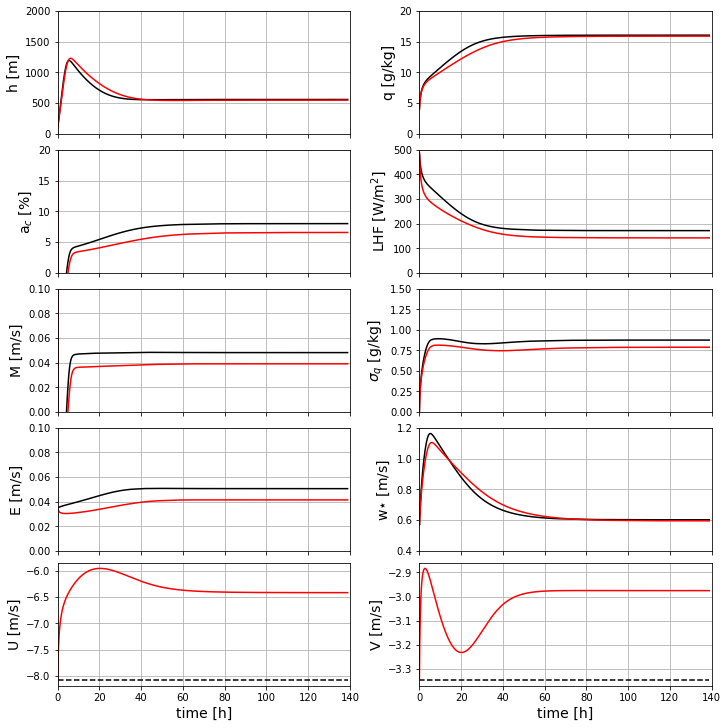

In [39]:
# Plots for a single run.
h = sol.y[0]
q = sol.y[1]
th = sol.y[2]
U = sol.y[3]
V = sol.y[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final = np.max(sol.t)
dt = t_final/3600/len(E_ext) # [h]
time_ext = np.arange(len(E_ext))*dt

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(area_c_ext[-1]*100)+'%')
print('equilibrium w$\star$ = '+str(w_star_ext[-1])+' m/s')

fig, ax = plt.subplots(5,2,figsize=(10,10),sharex=True,constrained_layout=True)

ax[0,0].plot(sol.t/3600,h_CV,'k')
ax[0,0].plot(sol.t/3600,h,'r')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()

ax[0,1].plot(sol.t/3600,q_CV*1e3,'k')
ax[0,1].plot(sol.t/3600,q*1e3,'r')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].set_ylim(0,20)
ax[0,1].grid()

#plt.plot(sol.t/3600,sol.y[2],'.')
#plt.ylabel('th [K]',fontsize=14)
#plt.xlabel('time [h]',fontsize=14)
#plt.grid()
#plt.show()

ax[1,0].plot(time_ext,np.array(area_c_ext_CV)*100,'k')
ax[1,0].plot(time_ext,np.array(area_c_ext)*100,'r')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()

ax[1,1].plot(time_ext,np.array(LHF_ext_CV),'k')
ax[1,1].plot(time_ext,np.array(LHF_ext),'r')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
ax[1,1].set_ylim(0,500)
ax[1,1].grid()

ax[2,0].plot(time_ext,np.array(M_ext_CV),'k')
ax[2,0].plot(time_ext,np.array(M_ext),'r')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(time_ext,np.array(sigma_q_ext_CV)*1e3,'k')
ax[2,1].plot(time_ext,np.array(sigma_q_ext)*1e3,'r')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

ax[3,0].plot(time_ext,np.array(E_ext_CV),'k')
ax[3,0].plot(time_ext,np.array(E_ext),'r')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].plot(time_ext,np.array(w_star_ext_CV),'k')
ax[3,1].plot(time_ext,np.array(w_star_ext),'r')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[4,0].hlines(U_free,np.min(sol.t/3600),np.max(sol.t/3600),'k',linestyle='dashed')
ax[4,0].plot(sol.t/3600,U,'r')
ax[4,0].set_ylabel('U [m/s]',fontsize=14)
#ax[4,0].set_ylim(0,0.10)
ax[4,0].grid()

ax[4,1].hlines(V_free,np.min(sol.t/3600),np.max(sol.t/3600),'k',linestyle='dashed')
ax[4,1].plot(sol.t/3600,V,'r')
ax[4,1].set_ylabel('V [m/s]',fontsize=14)
#ax[4,1].set_ylim(0,0.10)
ax[4,1].grid()

ax[4,0].set_xlabel('time [h]',fontsize=14)
ax[4,1].set_xlabel('time [h]',fontsize=14)
ax[4,0].set_xlim(0,140)
ax[4,1].set_xlim(0,140)

In [33]:
# One can check how the neggers et al solution looks like with the equilibrium wind values.

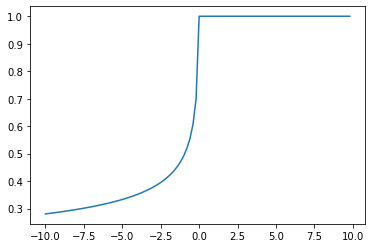

In [11]:
def prt_dyer74(zL):
    if zL>0:
        return 1
    else:
        return 1/(1-16*zL)**0.25

zL = np.arange(-10,10,0.2)
Prt = np.zeros((len(zL),))
for ii,z in enumerate(zL):
    Prt[ii] = prt_dyer74(z)
    
plt.plot(zL,Prt)